# Notebook for experiments and plots thesis
Contains snippets of large notebook "Playing around with ClIP" too

In [ ]:
import json
import os
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append("../data/")
# import style_package
plt.style.use("style_package.presentation")


## MALeViC data distribution

In [ ]:
def open_annotations(split='test', dataset='pos'):
  path = f'../data/{dataset}/annotation/'
  with open(path + f"{split}_annotation.json") as f1:
      annotation = json.load(f1)
  return annotation

def get_desc(annotation, img_id):
  """ Get description of an image as given in the annotations
  """ 
  return annotation[str(img_id)]
  

In [ ]:

# POS_data_location = '/content/drive/MyDrive/AA MSc Thesis/Data/MALeViC/pos/images/test/'
# POS_data_location = '/content/drive/MyDrive/AA MSc Thesis/Data/MALeViC/sup1/images/test/'
# POS_data_location = '/content/drive/MyDrive/AA MSc Thesis/Data/MALeViC/sup1/images/train/'
# POS_data_location = '/content/drive/MyDrive/AA MSc Thesis/Data/MALeViC/sup1/images/val/'

def make_labels_dict(split='train', dataset='pos'):
  imgs_path = f'../data/{dataset}/images/{split}/'
  annotation = open_annotations(split=split, dataset=dataset)
  labels = {}
  for img in os.listdir(imgs_path):
    img_id = int(img.replace('.png', ''))
    desc = get_desc(annotation, img_id)
    labels[img_id] = {
        'n_colors': desc[0]['n_colors'],
        'n_objects': desc[0]['n_objects']
    }
  return labels

In [ ]:
labels = make_labels_dict(split='test', dataset='pos')

In [ ]:
from collections import defaultdict

objective = 'n_objects'
# objective = 'n_colors'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.bar(x=count.keys(), height=count.values())
plt.title("Frequency distribution of " + objective)
plt.xticks([int(key) for key in count.keys()])

print(count)

In [ ]:
from collections import defaultdict
import matplotlib
# plt.style.use('seaborn-v0_8')
# import sys
# sys.path.append("../")
# sys.path.append("../style_package/")

import style_package
# test()
plt.style.use("style_package.presentation")


# matplotlib.rcParams['font.size'] = '100'

objective = 'n_objects'
# objective = 'n_colors'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.bar(x=count.keys(), height=count.values())
plt.title("Number of objects per image")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.ylim(0, 1000)
plt.xticks([int(key) for key in count.keys()])

print(count)

In [ ]:
labels = make_labels_dict(split='test', dataset='pos')
# objective = 'n_objects'
objective = 'n_colors'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.bar(x=count.keys(), height=count.values())
plt.title("Number of colors per image")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.ylim(0, 1000)
plt.xticks([int(key) for key in count.keys()])

In [ ]:
from collections import defaultdict
import matplotlib
plt.style.use('bmh')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

objective = 'n_objects'
# objective = 'n_colors'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.bar(x=count.keys(), height=count.values())
plt.title("Number of objects")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([int(key) for key in count.keys()])

print(count)

plt.subplot(1, 2, 1)
labels = make_labels_dict(split='test', dataset='pos')
objective = 'n_objects'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.bar(x=count.keys(), height=count.values())

plt.xticks([int(key) for key in count.keys()])
plt.title("Number of objects")
plt.ylabel("Frequency")

#plot 2:
labels = make_labels_dict(split='test', dataset='pos')
objective = 'n_colors'
count = defaultdict(lambda: 0)
for _, data in labels.items():
  count[int(data[objective])] += 1 

plt.subplot(1, 2, 2)
plt.bar(x=count.keys(), height=count.values())
plt.title("Number of colors")

plt.suptitle("Class frequency distribution test set POS")
plt.ylabel("")
plt.show()

## How many images are left in the balanced datasets?

In [ ]:
dataset = "pos"
split = "train"
objective = "n_colors"

import pickle
repr_path = f"../data/{dataset}/representations/{dataset}_{split}_balanced_{objective}_visual.pickle"

with open(repr_path, "rb") as f:
    reprs = pickle.load(f)

labels = make_labels_dict(split, dataset)


In [ ]:
len(reprs.keys())

In [ ]:
from collections import defaultdict
count =  defaultdict(lambda: 0)

for key in reprs.keys():
    count[labels[int(key)][objective]] += 1

In [ ]:
count

## Fix finding hard positives

In [ ]:
import random
import copy
import sys
sys.path.append("../code/")
from utils import get_neighboring_patches
from collections import defaultdict

def find_hard_positives_twopatches(patches):
    """input:
    patches (dict): keys = patch numbers ([0, 49]), values = boxes on patch

    returns:
    (int) patch_id, (int) patch_id, (0, 1) binary label indicating same object
    """
    boxes_dict = defaultdict(lambda: [])
    for patch_id, boxes in patches.items():
        for box in boxes:
            boxes_dict[box["object_id"]].append(patch_id)

    print("boxes_dict: ", boxes_dict)

    b_keys = list(boxes_dict.keys())
    random.shuffle(b_keys)
    for box in b_keys:
        patch_ids = boxes_dict[box]
        print("box ", box, " : ", patch_ids)
        for patch_id in patch_ids:
            patches_left = copy.deepcopy(patch_ids)
            patches_left.remove(patch_id)
            for neighbor in get_neighboring_patches(patch_id):
                if neighbor in patches_left:
                    patches_left.remove(neighbor)
                    print("remove ", neighbor, patches_left)
            if len(patches_left) > 0:
                patch2 = random.sample(patches_left, 1)[0]
                return patch_id, patch2, 1

    # if nothing is returned by now, there are no patches of the same object that are not neighbors.
    # then, just return -1, -1
    return -1, -1, 0

In [ ]:
import transformer_patches

img_id = "9352"
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "train")
print(find_hard_positives_twopatches(patches))
transformer_patches.open_image_withpatches(f"{img_id}.png", "pos", "train", to_save=False)

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


[{0: {'error': 7.241, 'accuracy': 0.001}, 1: {'error': 6.012, 'accuracy': 0.0035}, 2: {'error': 5.8365, 'accuracy': 0.004}, 3: {'error': 0.7515, 'accuracy': 0.431}, 4: {'error': 0.8655, 'accuracy': 0.3835}, 5: {'error': 0.445, 'accuracy': 0.6145}, 6: {'error': 0.4855, 'accuracy': 0.587}, 7: {'error': 0.2975, 'accuracy': 0.726}, 8: {'error': 0.3225, 'accuracy': 0.727}, 9: {'error': 0.412, 'accuracy': 0.6455}, 10: {'error': 0.4615, 'accuracy': 0.617}, 11: {'error': 1.288, 'accuracy': 0.3555}, 12: {'error': 1.2935, 'accuracy': 0.344}, 13: {'error': 1.738, 'accuracy': 0.2475}, 14: {'error': 2.2905, 'accuracy': 0.1735}}]


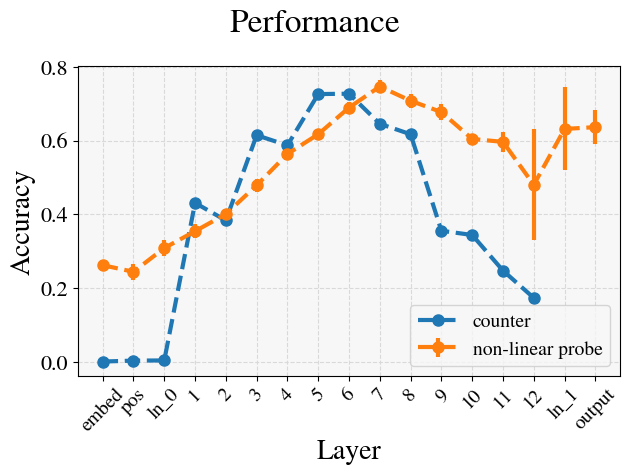

In [1]:
import sys
sys.path.append("../code/")
import visualize_result
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")

config = {
    "no_plots": 1,
    "filenames": [
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_productproduct.pickle",
        # "../results/test_results_MLP2_pos_binding_problem_unbalanced_filtered_{30}_no_layernorm.pickle",
    ],
    "labels": [
        "counter",
        # "Bayesian",
    ],
    "fig_title": "Performance",
    "save": True,
    "img_name": "performancecountervsprobe.png",
    "only_transformer": False,
    "entire_y_axis": False,
    "counter": False,
    }

results = visualize_result.plot_results_counter(config)

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


[{0: {'error': 7.084, 'accuracy': 0.0025}, 1: {'error': 5.863, 'accuracy': 0.0055}, 2: {'error': 5.721, 'accuracy': 0.0065}, 3: {'error': 0.8075, 'accuracy': 0.405}, 4: {'error': 0.9435, 'accuracy': 0.354}, 5: {'error': 0.456, 'accuracy': 0.6015}, 6: {'error': 0.512, 'accuracy': 0.577}, 7: {'error': 0.322, 'accuracy': 0.7045}, 8: {'error': 0.349, 'accuracy': 0.7}, 9: {'error': 0.4415, 'accuracy': 0.617}, 10: {'error': 0.504, 'accuracy': 0.585}, 11: {'error': 1.2055, 'accuracy': 0.372}, 12: {'error': 1.241, 'accuracy': 0.343}, 13: {'error': 1.605, 'accuracy': 0.272}, 14: {'error': 2.1565, 'accuracy': 0.189}}, {0: {'error': 7.241, 'accuracy': 0.001}, 1: {'error': 6.012, 'accuracy': 0.0035}, 2: {'error': 5.8365, 'accuracy': 0.004}, 3: {'error': 0.7515, 'accuracy': 0.431}, 4: {'error': 0.8655, 'accuracy': 0.3835}, 5: {'error': 0.445, 'accuracy': 0.6145}, 6: {'error': 0.4855, 'accuracy': 0.587}, 7: {'error': 0.2975, 'accuracy': 0.726}, 8: {'error': 0.3225, 'accuracy': 0.727}, 9: {'error': 0

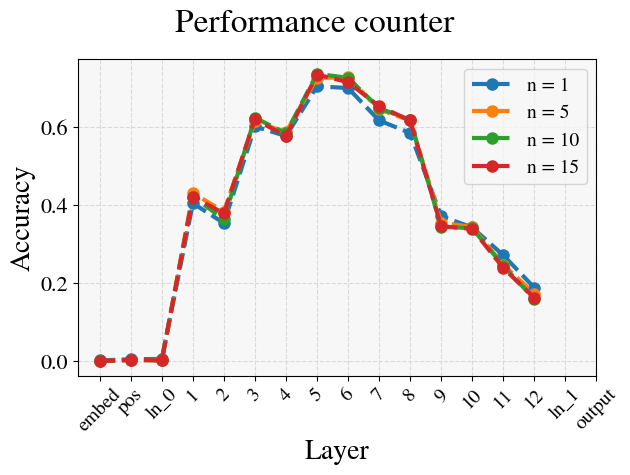

In [13]:
import sys
sys.path.append("../code/")
import visualize_result
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")

config = {
    "no_plots": 3,
    "filenames": [
        "../results/results_counter_pos_bindingprobe:MLP2.pickle",
        # "../results/results_counter_pos_bindingprobe_MLP2_test_check.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_productproduct.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_10_test_productproduct.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_15_test_productproduct.pickle",
    ],
    "labels": [
        "n = 1",
        "n = 5",
        "n = 10",
        "n = 15",
    ],
    "fig_title": "Performance counter",
    "save": True,
    "img_name": "performancecounters_differentn.png",
    "only_transformer": False,
    "entire_y_axis": False,
    "counter":True,
    }

results = visualize_result.plot_results_counter(config)

In [ ]:
import sys
import matplotlib.pyplot as plt
sys.path.append("../code/")
import visualize_result
plt.style.use("style_package.presentation")

config = {
    "no_plots": 3,
    "filenames": [
        "../results/test_results_MLP2_pos_object_det.pickle",
    ],
    "labels": [
        "",
    ],
    "fig_title": "Performance detector probe",
    "save": True,
    "img_name": "performancedetector_probe.png",
    "only_transformer": False,
    "entire_y_axis": True,
    }

results = visualize_result.plot_accuracy_probes(config)



Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


[{0: {'error': 7.241, 'accuracy': 0.001}, 1: {'error': 6.012, 'accuracy': 0.0035}, 2: {'error': 5.8365, 'accuracy': 0.004}, 3: {'error': 0.7515, 'accuracy': 0.431}, 4: {'error': 0.8655, 'accuracy': 0.3835}, 5: {'error': 0.445, 'accuracy': 0.6145}, 6: {'error': 0.4855, 'accuracy': 0.587}, 7: {'error': 0.2975, 'accuracy': 0.726}, 8: {'error': 0.3225, 'accuracy': 0.727}, 9: {'error': 0.412, 'accuracy': 0.6455}, 10: {'error': 0.4615, 'accuracy': 0.617}, 11: {'error': 1.288, 'accuracy': 0.3555}, 12: {'error': 1.2935, 'accuracy': 0.344}, 13: {'error': 1.738, 'accuracy': 0.2475}, 14: {'error': 2.2905, 'accuracy': 0.1735}}, {0: {'error': 6.7635, 'accuracy': 0.0025}, 1: {'error': 5.614, 'accuracy': 0.0095}, 2: {'error': 5.427, 'accuracy': 0.0045}, 3: {'error': 0.6545, 'accuracy': 0.473}, 4: {'error': 0.715, 'accuracy': 0.4415}, 5: {'error': 0.5365, 'accuracy': 0.546}, 6: {'error': 0.419, 'accuracy': 0.6315}, 7: {'error': 0.339, 'accuracy': 0.693}, 8: {'error': 0.3655, 'accuracy': 0.6785}, 9: {'

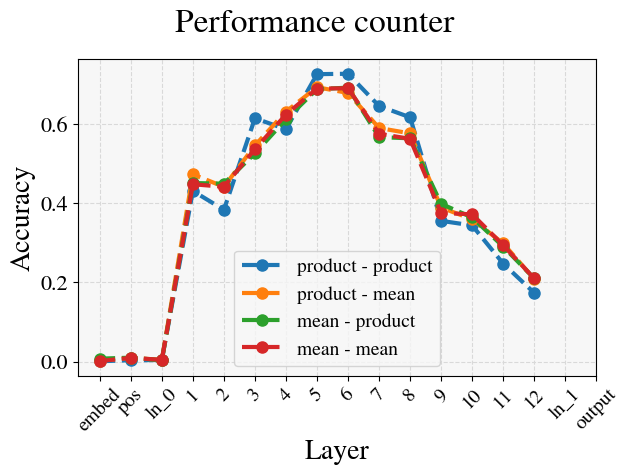

In [12]:
import sys
sys.path.append("../code/")
import visualize_result
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")

config = {
    "no_plots": 2,
    "filenames": [
        # "../results/results_counter_pos_bindingprobe:MLP2.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_productproduct.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_productmean.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_meanproduct.pickle",
        # "../results/results_counter2_pos_bindingprobe_MLP2_n_1_test_meanmean_noshuffle.pickle",
        "../results/results_counter2_pos_bindingprobe_MLP2_n_5_test_meanmean.pickle",
    ],
    "labels": [
        # "n = 1",
        "product - product",
        "product - mean",
        "mean - product",
        "mean - mean",
    ],
    "fig_title": "Performance counter",
    "save": False,
    "img_name": "performancecounters_differentmodes.png",
    "only_transformer": False,
    "entire_y_axis": False,
    "counter":True,
    }

results = visualize_result.plot_results_counter(config)

## Obtain confusion matrices for probes on numerosity

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 7, 8, 9])
Will try to open representations of pos of split test
Balanced is: True
dict_values([5, 6, 

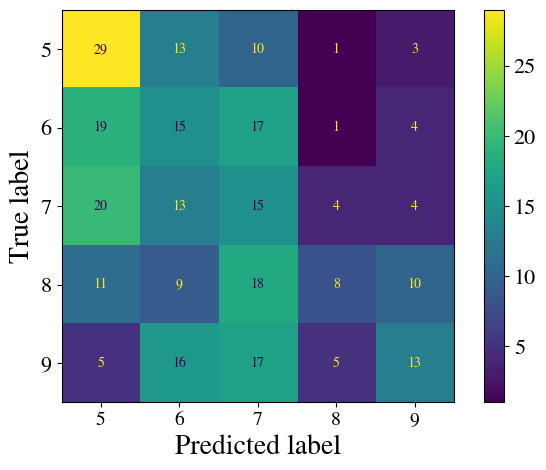

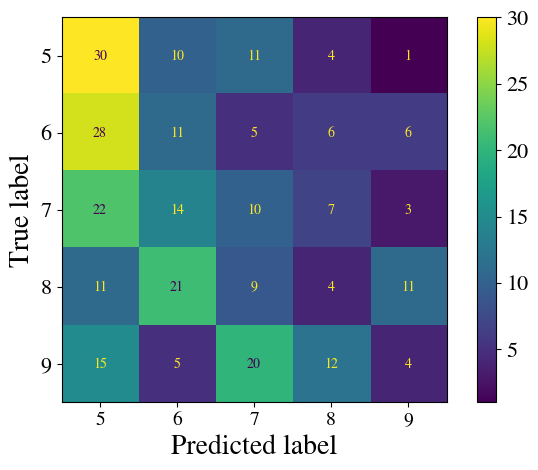

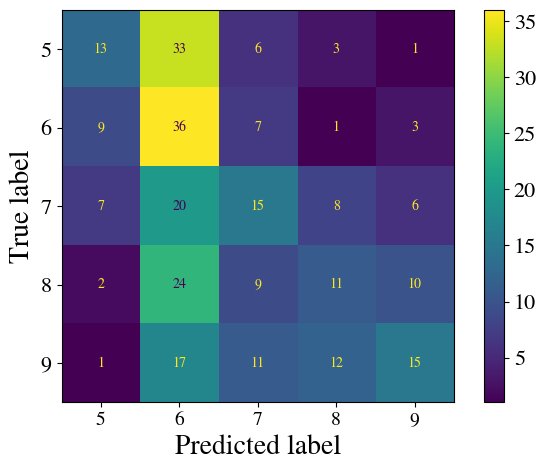

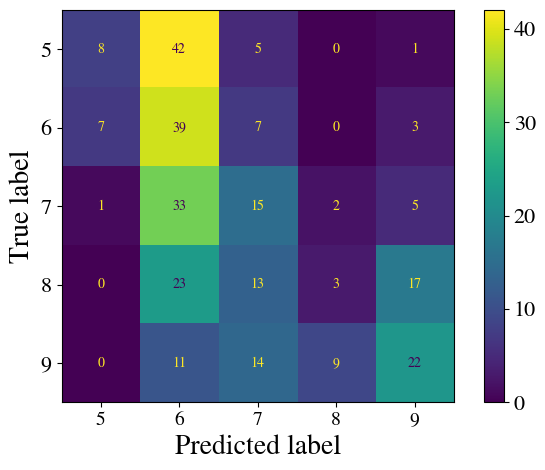

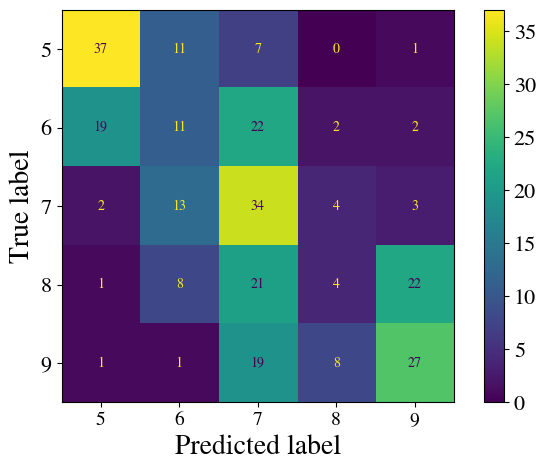

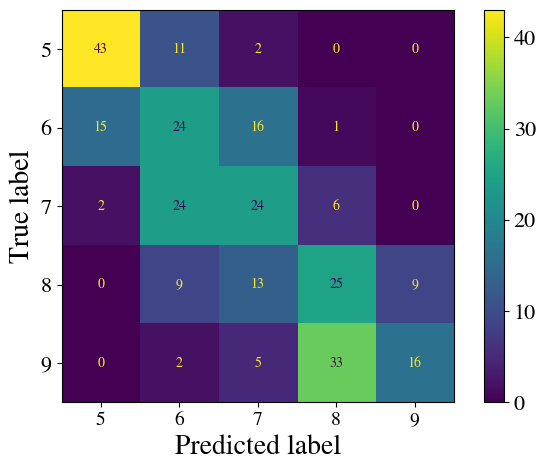

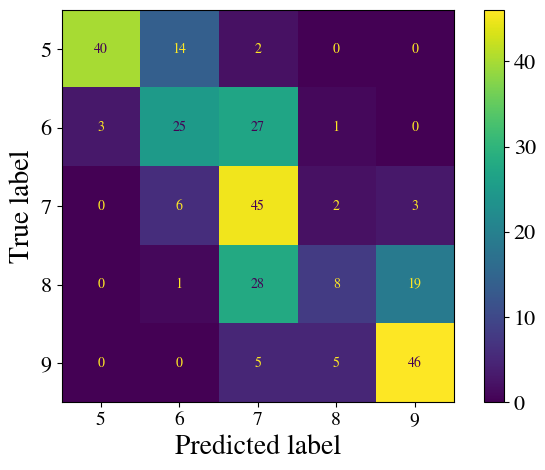

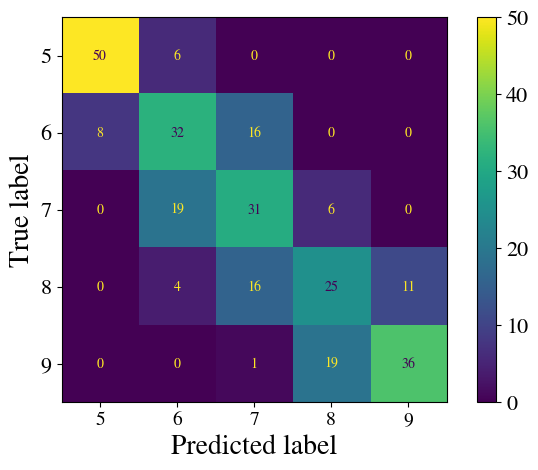

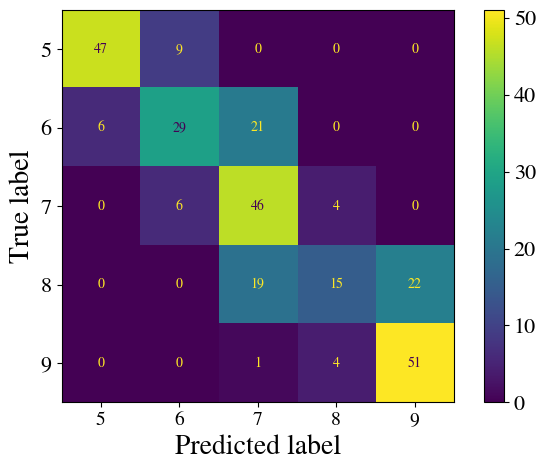

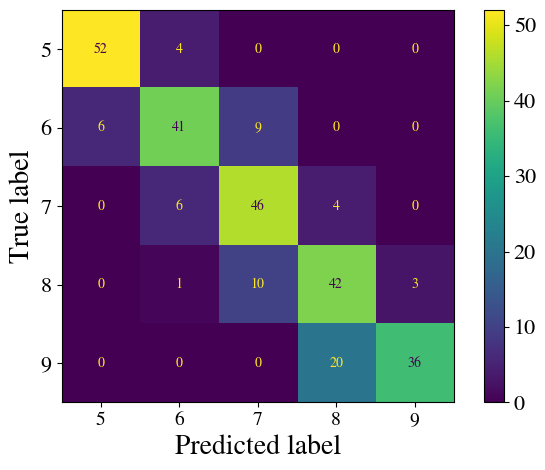

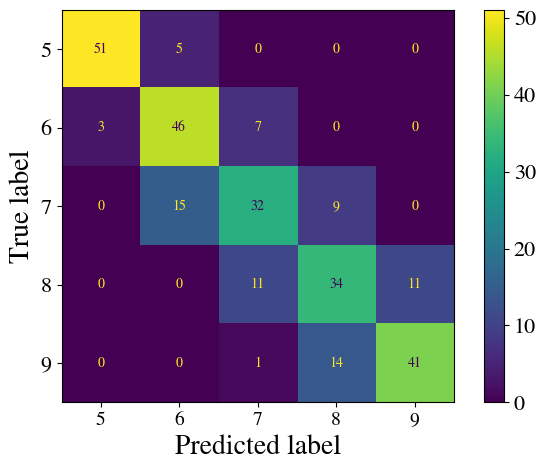

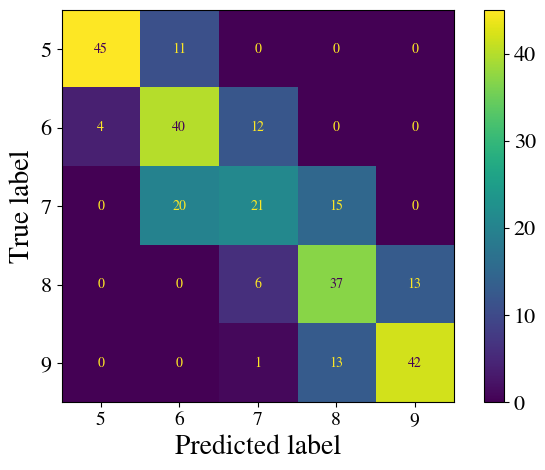

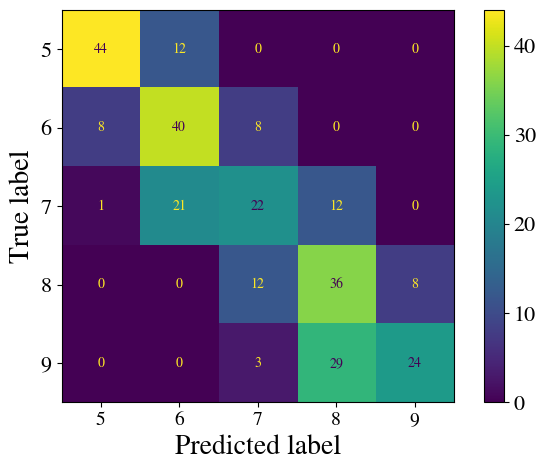

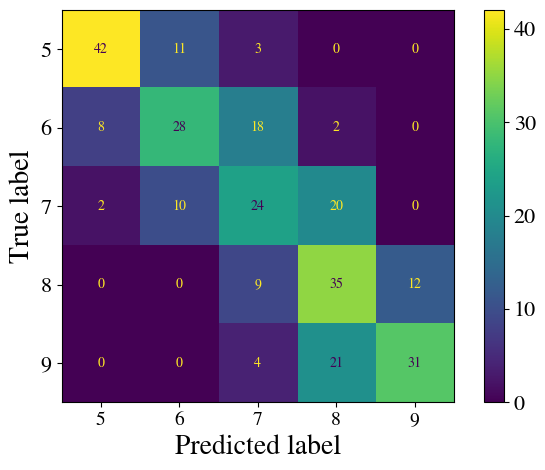

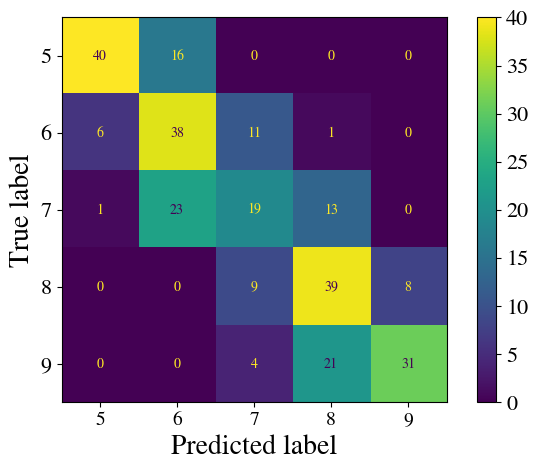

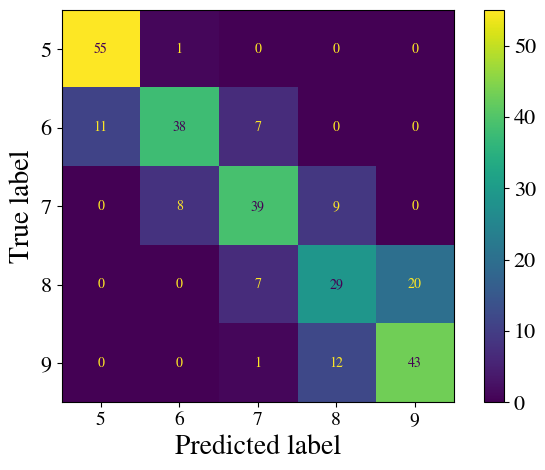

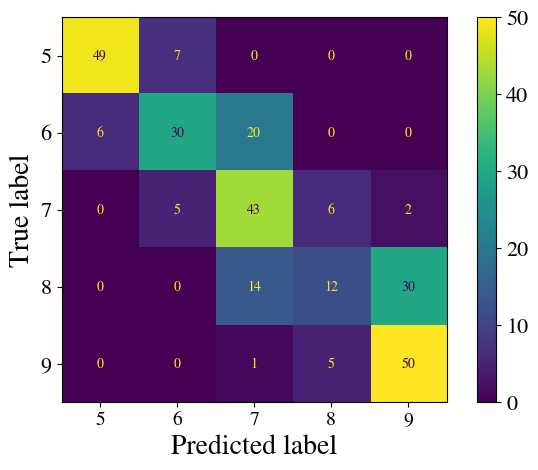

In [2]:
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")
import sys
sys.path.append("../code/")
sys.path.append("../models/")
import utils
import evaluate_errors

def get_confusionmatrix(layer):
    objective = "n_objects"
    dataset = "pos"
    modelname = "MLP2"
    balanced = True
    layernorm = False

    actual, predicted = evaluate_errors.obtain_predictions(
        objective,
        dataset,
        modelname=modelname,
        layer=layer,
        balanced=balanced,
        layernorm=layernorm,
    )


    # img_title = f"Layer {layer}"
    img_title = ""
    class2label, _ = utils.get_classlabel(dataset, "test", objective)
    evaluate_errors.get_confusion_matrix(actual, predicted, class2label, img_title)

    img_name = f'(layer {layer}, {objective}, {modelname}, {dataset}, {"balanced" if balanced else "unbalanced"}, {"layernorm" if layernorm else "no layernorm"})'
    img_name = "../plots/cm_" + img_name + ".png"
    img_name.replace(" ", "_")
    plt.grid(False)
    plt.savefig(img_name, bbox_inches="tight")

for layer in range(17):
    get_confusionmatrix(layer)

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


tensor([0.5013, 0.4987], grad_fn=<SoftmaxBackward0>)


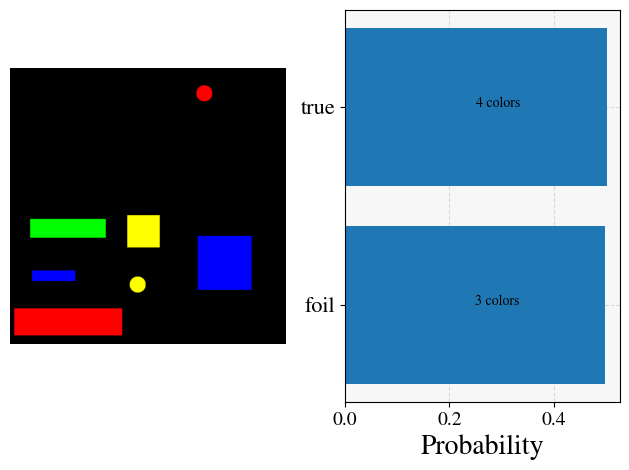

In [9]:
import sys
sys.path.append("../code/")
import clipscores
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")
import sys
import utils
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = utils.get_model_preprocess(device, model_type="ViT-B/32")
clipscores.show_example(str(1), "test", "pos", "n_colors", model, device)

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


tensor([0.4997, 0.5003], grad_fn=<SoftmaxBackward0>)


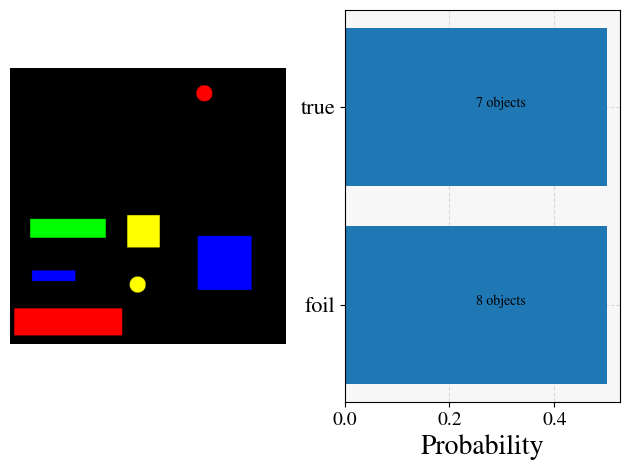

In [10]:
import sys
sys.path.append("../code/")
import clipscores
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")
import sys
import utils
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = utils.get_model_preprocess(device, model_type="ViT-B/32")
clipscores.show_example(str(1), "test", "pos", "n_objects", model, device)

In [3]:
import sys
sys.path.append("../code/")
import visualize_result
import matplotlib.pyplot as plt
plt.style.use("style_package.presentation")

config = {
    "no_plots": 2,
    "filenames": [
        "../results/test_results_linear_layer_pos_shape_unbalanced_filtered_{30}_single_patch_no_layernorm.pickle",
        "../results/test_results_MLP2_pos_shape_unbalanced_filtered_{30}_single_patch_no_layernorm.pickle",
    ],
    "labels": [
        "linear",
        "non-linear",
        "majority"
    ],
    "fig_title": "Single patch probing for shape",
    "save": False,
    "img_name": "probes_singlepatch_shape.png",
    "only_transformer": False,
    "entire_y_axis": False,
    "counter": False,
    }

results = visualize_result.plot_results_counter(config)

Bad value in file PosixPath('/Users/avansprang/Documents/MSc Thesis/numerosity_thesis/malevic-master/code_for_trying/style_package/presentation.mplstyle'), line 10 ("mathtext.fontset : 'stix'"): Key mathtext.fontset: "'stix'" is not a valid value for mathtext.fontset; supported values are ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']; remove quotes surrounding your string


FileNotFoundError: [Errno 2] No such file or directory: '../results/test_results_MLP2_pos_shape_unbalanced_filtered_{30}_single_patch_no_layernorm.pickle'